In [1]:
import pandas as pd
df= pd.read_csv('../data/raw/train.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df["SalePrice"],kde=True)
plt.show()
df["SalePrice"].describe()
df["SalePrice"].skew()

The target variable is right-skewed, meaning most houses are moderately priced while a few very expensive houses create a long right tail

In [ ]:
numeric_features = []
ordinal_features = []
nominal_features = []

Numeric: Real measurements or counts
Ordinal:Categories with a clear order
Nominal:Categories with no order

In [ ]:
numeric_features.extend([
    "LotFrontage",
    "LotArea",
    "GrLivArea",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "GarageArea",
    "GarageCars",
    "YearBuilt",
    "YearRemodAdd",
    "YrSold",
    "MoSold"
])

ordinal_features.extend([
    "OverallQual",
    "OverallCond",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond"
])

nominal_features.extend([
    "Neighborhood",
    "MSZoning",
    "HouseStyle",
    "BldgType",
    "RoofStyle",
    "Exterior1st",
    "Exterior2nd",
    "Foundation",
    "SaleType",
    "SaleCondition"
])

In [ ]:
missing=df.isnull().sum()
missing=missing[missing>0].sort_values(ascending=False)
missing

Several features (PoolQC, Fence, FireplaceQu) have missing values because many houses do not have these features

These missing values are meaningful and represent absence rather than data errors

Such features should not be dropped and will require careful handling later

Group 1:Structural Missing
1. PoolQC
2. MiscFeature
3. Alley
4. Fence
5. FireplaceQu
6. GarageType       
7. GarageYrBlt       
8. GarageFinish      
9. GarageQual        
10. GarageCond        
11. BsmtFinType2      
12. BsmtExposure      
13. BsmtFinType1      
14. BsmtCond          
15. BsmtQual          
16. MasVnrType

Group 2: Missing Data
1. LotFrontage
2. MasVnrArea
3. Electrical


In [ ]:
qual_map={
    "Po":1,
    "Fa":2,
    "TA":3,
    "Gd":4,
    "Ex":5
}

ordinal_cols=[
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond"
]

for col in ordinal_cols:
    df[col]=df[col].fillna("Po")

In [ ]:
df[ordinal_cols].describe()


In [ ]:
df.isnull().sum()[df.isnull().sum()>0]

In [ ]:
df["LotFrontage"]=df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [ ]:
df["MasVnrType"] = df["MasVnrType"].fillna("None")

In [ ]:
df["Electrical"]=df["Electrical"].fillna(df["Electrical"].mode()[0])

In [ ]:
structural_cat_cols = [
    "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
    "GarageType", "GarageFinish", "GarageQual", "GarageCond",
    "BsmtFinType2", "BsmtExposure", "BsmtFinType1",
    "BsmtCond", "BsmtQual", "MasVnrType"
]

for col in structural_cat_cols:
    df[col] = df[col].fillna("None")
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(0)
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

In [ ]:
df.isnull().sum().max()

In [ ]:
import numpy as np
df["SalePrice_Log"] = np.log(df["SalePrice"])

In [ ]:
X = df.drop(columns=["SalePrice", "SalePrice_Log"])
y = df["SalePrice_Log"]

In [ ]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

np.float64(0.17309120595421085)

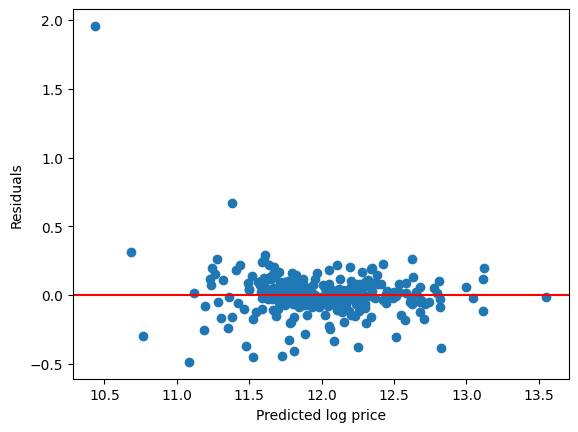

In [21]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color="red")
plt.xlabel("Predicted log price")
plt.ylabel("Residuals")
plt.show()

In [24]:
residuals = y_test - y_pred

outliers = pd.DataFrame({
    "Predicted": y_pred,
    "Actual": y_test,
    "Residual": residuals
}).sort_values(by="Residual", ascending=False)

outliers.head(5)

,Predicted,Actual,Residual
271,10.437468,12.394625,1.957157
1170,11.379859,12.049419,0.669559
636,10.686949,11.002100,0.315151
365,11.609672,11.898188,0.288516
774,12.621955,12.886641,0.264686


In [25]:
outliers.tail(5)

,Predicted,Actual,Residual
581,12.826800,12.442302,-0.384497
479,11.810405,11.401670,-0.408736
589,11.725251,11.283512,-0.441738
1432,11.524545,11.074421,-0.450124
30,11.083393,10.596635,-0.486758


In [26]:
outlier_indices = outliers.head(5).index
df.loc[outlier_indices]


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_Log
271,272,20,RL,73.0,39104,Pave,None,IR1,Low,AllPub,...,None,None,None,0,4,2008,WD,Normal,241500,12.394625
1170,1171,80,RL,76.0,9880,Pave,None,Reg,Lvl,AllPub,...,Gd,GdPrv,None,0,7,2008,WD,Normal,171000,12.049419
636,637,30,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,None,None,None,0,1,2009,ConLw,Normal,60000,11.002100
365,366,70,RM,59.0,10690,Pave,None,Reg,Lvl,AllPub,...,None,None,None,0,7,2009,WD,Normal,147000,11.898188
774,775,20,RL,110.0,14226,Pave,None,Reg,Lvl,AllPub,...,None,None,None,0,7,2007,New,Partial,395000,12.886641


Inspection of extreme residuals shows that outliers correspond to legitimate but heterogeneous properties (e.g., large lots, high-end or atypical sales). These were retained, as errors stem from linear model limitations rather than data quality issues.